In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [77]:
import numpy as np
import os
from glob import glob
import pandas as pd
import tensorflow as tf
import cv2 as cv
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
from tensorflow.python.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.keras.layers import  Dropout, Conv2D, MaxPooling2D,MaxPool2D,GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model,Sequential
from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

import warnings
warnings.filterwarnings("ignore")


In [78]:
train_path="../input/coviddata/train"
test_path="../input/coviddata/test"
print("Test images dataset"+str(os.listdir(train_path)))
print("Test images dataset"+str(os.listdir(test_path)))

Test images dataset['Normal', 'Viral Pneumonia', 'Covid']
Test images dataset['Normal', 'Viral Pneumonia', 'Covid']


In [79]:
IMAGE_SIZE=[244,244]
label=['Covid','Normal','Viral Pneumonia']

In [80]:
folder=glob(train_path+'/*')
folder

['../input/coviddata/train/Normal',
 '../input/coviddata/train/Viral Pneumonia',
 '../input/coviddata/train/Covid']

In [81]:
from tqdm import tqdm
class_names = label
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (244,244)

In [82]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = [train_path, test_path]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv.imread(img_path)
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [83]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train, y_train = shuffle(x_train,y_train, random_state=25)
n_train = y_train.shape[0]
n_test = y_test.shape[0]
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Loading ../input/coviddata/train


100%|██████████| 111/111 [00:04<00:00, 27.52it/s]


Loading ../input/coviddata/test


100%|██████████| 26/26 [00:00<00:00, 95.59it/s] 


Number of training examples: 251
Number of testing examples: 66
Each image is of size: (244, 244)


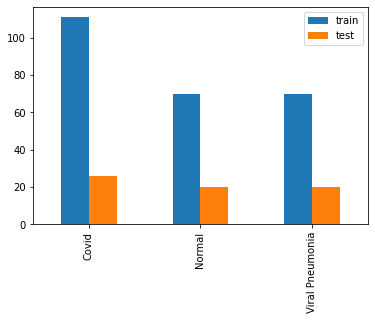

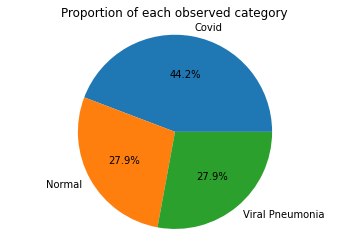

In [84]:
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=label
            ).plot.bar()

plt.show()

plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()


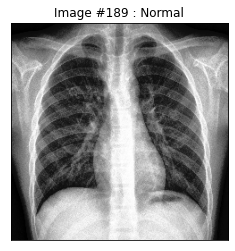

In [85]:
def display_random_images(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

display_random_images(label,x_train,y_train)

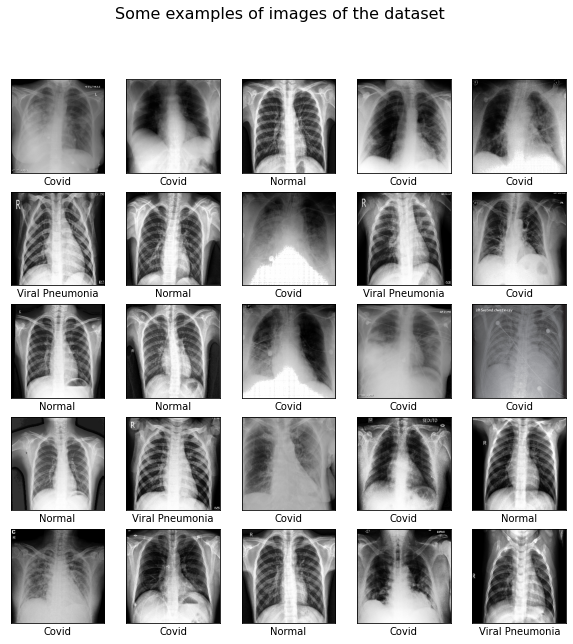

In [86]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(label,x_train,y_train)

In [87]:
data_augmentation=False
batch_sizes=[32,64,120]
epoch_num=[20,50,100]
data_aug=[True,False]

### Plotting accuracy and loss

In [88]:

def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,20))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [89]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(251, 244, 244, 3)
(66, 244, 244, 3)
(251,)
(66,)


#### Data Augmentation

In [90]:
def data_augmen(batch_size,epochs,data_augmentation):
    if data_augmentation==False:
        print('No data augmentation.')
#         model.fit(x_train, y_train,
#                   batch_size=batch_size,
#                   epochs=epochs,
#                   validation_data=(x_test, y_test),
#                   shuffle=True,
#                   callbacks=callbacks)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

### CNN- Model

In [ ]:
#Model 1
def build_model_1():
    model=Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(244,244,3)))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1,activation='sigmoid'))



    model.compile(optimizer = "rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
for batch_size in batch_sizes:
    for epochs in epoch_num:
        for data_au in data_aug:
            (x_train, y_train), (x_test, y_test) = load_data()
            x_train, y_train = shuffle(x_train,y_train, random_state=25)
            n_train = y_train.shape[0]
            n_test = y_test.shape[0]
            # Normalize data.
            x_train = x_train.astype('float32') / 255
            x_test = x_test.astype('float32') / 255

            model=build_model_1()
            data_augmen(batch_size,epochs,data_au)
            print("Batch_size:",batch_size)
            print("Epochs:",epochs)
            print("Data Augmentation:",data_au)
            
            model.compile(optimizer = "rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

            early_stop = EarlyStopping(monitor='val_loss',patience=2)
            history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                                validation_data=(x_test,y_test), verbose=2)
            plot_accuracy_loss(history)
            


### Model 2

In [ ]:
# Model 2
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (244,244, 3)), 
        BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(6, activation=tf.nn.softmax)
    ])
    return model

In [ ]:
for batch in batch_sizes:
    for epoch in epoch_num:
        for data_au in data_aug:
            
            (x_train, y_train), (x_test, y_test) = load_data()
            x_train, y_train = shuffle(x_train,y_train, random_state=25)
            n_train = y_train.shape[0]
            n_test = y_test.shape[0]
            # Normalize data.
            x_train = x_train.astype('float32') / 255
            x_test = x_test.astype('float32') / 255

            model=build_model_2()

            data_augmen(batch,epoch,data_au)
            print("Batch_size:",batch)
            print("Epochs:",epoch)
            print("Data Augmentation:",data_au)

            model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])            
            history = model.fit(x_train,y_train, batch_size=batch, epochs=epoch, validation_split = 0.2)
            plot_accuracy_loss(history)



#### Model 3- CNN

In [98]:
#Model 3
def build_model_3():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=3, activation='softmax')
    ])
    return model

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_201 (Conv2D)          (None, 240, 240, 128)     9728      
_________________________________________________________________
activation_69 (Activation)   (None, 240, 240, 128)     0         
_________________________________________________________________
module_wrapper_214 (ModuleWr (None, 120, 120, 128)     0         
_________________________________________________________________
batch_normalization_141 (Bat (None, 120, 120, 128)     512       
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 118, 118, 64)      73792     
_____________________________________________________

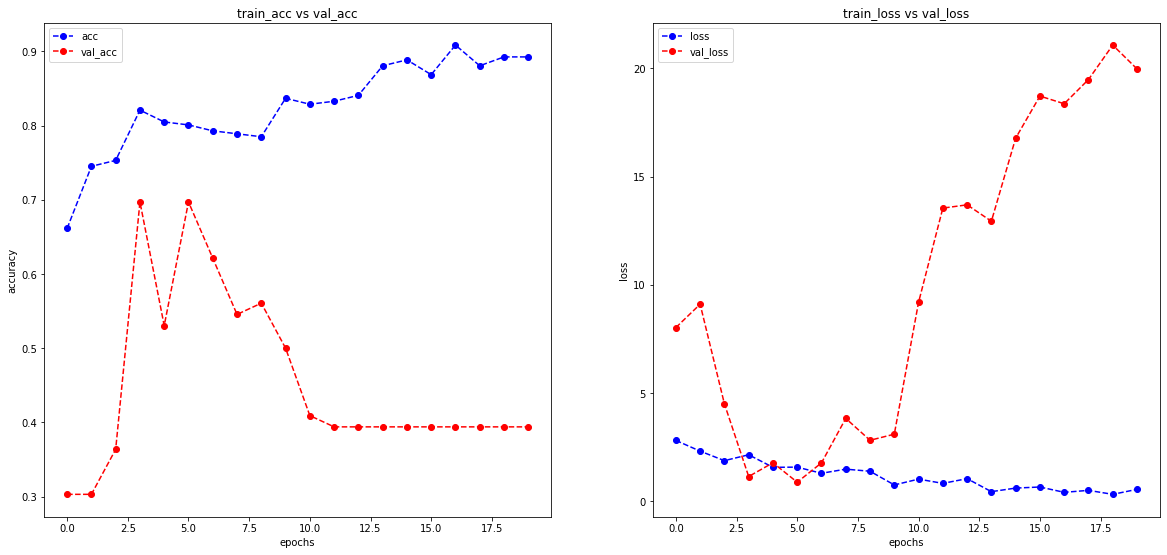

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 32
Epochs: 50
Epoch 1/50
8/8 - 15s - loss: 2.4649 - accuracy: 0.6375 - val_loss: 5.8658 - val_accuracy: 0.3030
Epoch 2/50
8/8 - 15s - loss: 1.6968 - accuracy: 0.7689 - val_loss: 7.6377 - val_accuracy: 0.3030
Epoch 3/50
8/8 - 14s - loss: 1.4148 - accuracy: 0.7928 - val_loss: 5.5737 - val_accuracy: 0.3636
Epoch 4/50
8/8 - 14s - loss: 1.2041 - accuracy: 0.8526 - val_loss: 1.6962 - val_accuracy: 0.5455
Epoch 5/50
8/8 - 14s - loss: 0.8287 - accuracy: 0.8127 - val_loss: 1.1784 - val_accuracy: 0.5909
Epoch 6/50
8/8 - 14s - loss: 1.5703 - accuracy: 0.7729 - val_loss: 1.2716 - val_accuracy: 0.6515
Epoch 7/50
8/8 - 14s - loss: 1.3658 - accuracy: 0.8048 - val_loss: 9.6674 - val_accuracy: 0.3939
Epoch 8/50
8/8 - 14s - loss: 1.6124 - accuracy: 0.7649 - val_loss: 12.9939 - val_accuracy: 0.393

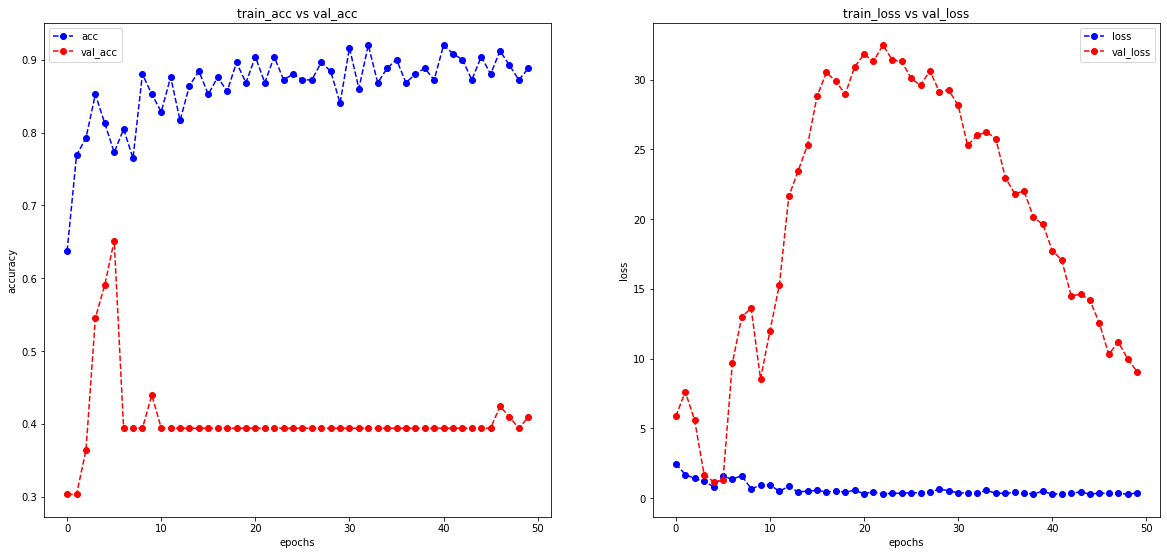

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 32
Epochs: 100
Epoch 1/100
8/8 - 16s - loss: 4.0048 - accuracy: 0.6335 - val_loss: 8.9948 - val_accuracy: 0.3182
Epoch 2/100
8/8 - 14s - loss: 3.1869 - accuracy: 0.7570 - val_loss: 5.4865 - val_accuracy: 0.3485
Epoch 3/100
8/8 - 13s - loss: 3.0236 - accuracy: 0.7769 - val_loss: 5.2232 - val_accuracy: 0.3485
Epoch 4/100
8/8 - 14s - loss: 2.2346 - accuracy: 0.7610 - val_loss: 2.9031 - val_accuracy: 0.4242
Epoch 5/100
8/8 - 14s - loss: 2.2169 - accuracy: 0.7689 - val_loss: 5.0042 - val_accuracy: 0.3636
Epoch 6/100
8/8 - 14s - loss: 1.6392 - accuracy: 0.8207 - val_loss: 1.7878 - val_accuracy: 0.5606
Epoch 7/100
8/8 - 14s - loss: 1.1211 - accuracy: 0.8048 - val_loss: 5.3205 - val_accuracy: 0.5152
Epoch 8/100
8/8 - 14s - loss: 1.5306 - accuracy: 0.8088 - val_loss: 5.1050 - val_accurac

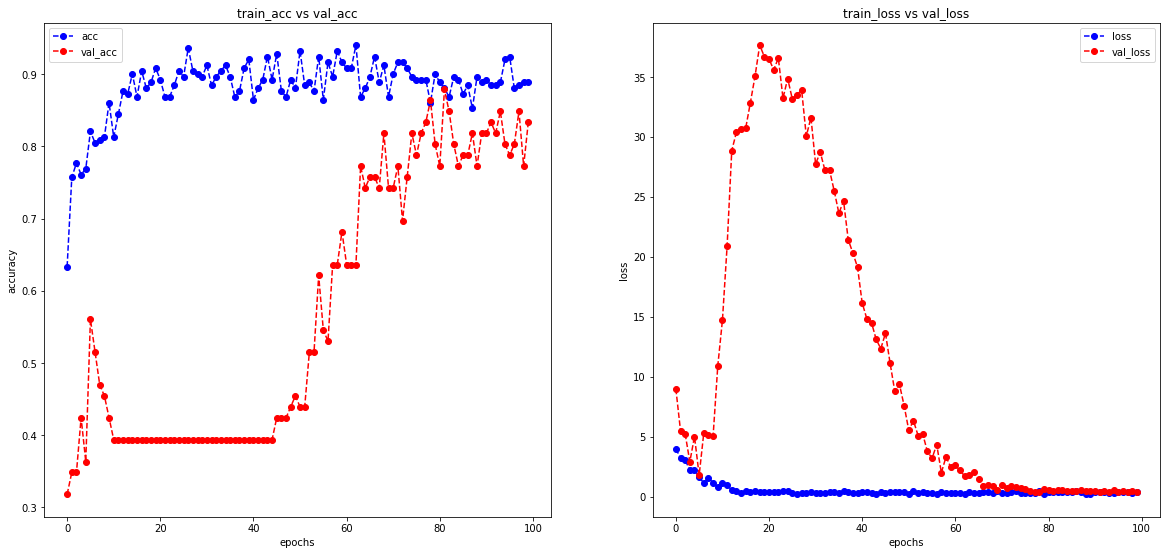

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 64
Epochs: 20
Epoch 1/20
4/4 - 18s - loss: 3.6046 - accuracy: 0.5697 - val_loss: 1.3735 - val_accuracy: 0.3182
Epoch 2/20
4/4 - 14s - loss: 2.1595 - accuracy: 0.7530 - val_loss: 2.4965 - val_accuracy: 0.3182
Epoch 3/20
4/4 - 14s - loss: 2.3608 - accuracy: 0.7928 - val_loss: 2.1516 - val_accuracy: 0.3636
Epoch 4/20
4/4 - 14s - loss: 1.5061 - accuracy: 0.8446 - val_loss: 2.1494 - val_accuracy: 0.3485
Epoch 5/20
4/4 - 15s - loss: 1.5068 - accuracy: 0.7968 - val_loss: 3.0448 - val_accuracy: 0.3485
Epoch 6/20
4/4 - 14s - loss: 0.8459 - accuracy: 0.8048 - val_loss: 3.6295 - val_accuracy: 0.2879
Epoch 7/20
4/4 - 14s - loss: 1.0346 - accuracy: 0.7649 - val_loss: 2.1322 - val_accuracy: 0.4545
Epoch 8/20
4/4 - 14s - loss: 0.8343 - accuracy: 0.8327 - val_loss: 1.4948 - val_accuracy: 0.5152

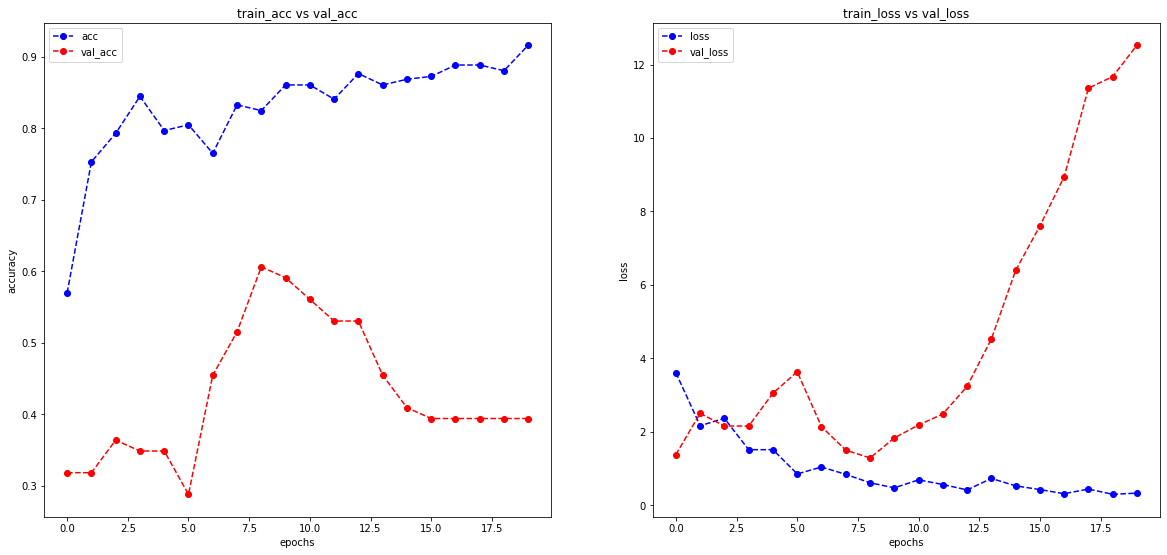

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 64
Epochs: 50
Epoch 1/50
4/4 - 17s - loss: 3.1309 - accuracy: 0.5578 - val_loss: 9.1742 - val_accuracy: 0.3030
Epoch 2/50
4/4 - 14s - loss: 2.7534 - accuracy: 0.7052 - val_loss: 5.5354 - val_accuracy: 0.3030
Epoch 3/50
4/4 - 14s - loss: 1.6611 - accuracy: 0.7689 - val_loss: 3.9987 - val_accuracy: 0.3030
Epoch 4/50
4/4 - 14s - loss: 0.8380 - accuracy: 0.8207 - val_loss: 4.3005 - val_accuracy: 0.3030
Epoch 5/50
4/4 - 14s - loss: 0.9881 - accuracy: 0.8287 - val_loss: 5.7194 - val_accuracy: 0.3030
Epoch 6/50
4/4 - 14s - loss: 0.9452 - accuracy: 0.8247 - val_loss: 8.3831 - val_accuracy: 0.3182
Epoch 7/50
4/4 - 14s - loss: 0.9780 - accuracy: 0.8048 - val_loss: 7.8963 - val_accuracy: 0.3939
Epoch 8/50
4/4 - 14s - loss: 0.8185 - accuracy: 0.8327 - val_loss: 8.2203 - val_accuracy: 0.3636

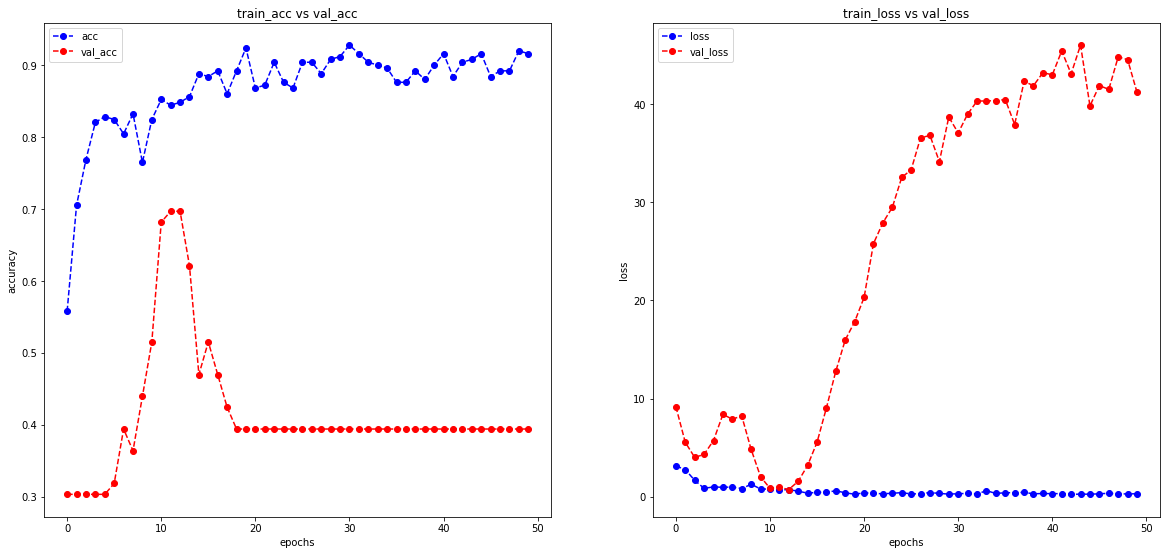

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 64
Epochs: 100
Epoch 1/100
4/4 - 17s - loss: 2.9230 - accuracy: 0.6016 - val_loss: 3.0422 - val_accuracy: 0.3030
Epoch 2/100
4/4 - 14s - loss: 1.3693 - accuracy: 0.7610 - val_loss: 1.6372 - val_accuracy: 0.4242
Epoch 3/100
4/4 - 14s - loss: 1.5461 - accuracy: 0.7649 - val_loss: 0.8674 - val_accuracy: 0.6364
Epoch 4/100
4/4 - 15s - loss: 1.3086 - accuracy: 0.7888 - val_loss: 1.4545 - val_accuracy: 0.4697
Epoch 5/100
4/4 - 14s - loss: 1.5242 - accuracy: 0.7450 - val_loss: 3.6254 - val_accuracy: 0.4091
Epoch 6/100
4/4 - 15s - loss: 1.1071 - accuracy: 0.7809 - val_loss: 2.7008 - val_accuracy: 0.3939
Epoch 7/100
4/4 - 14s - loss: 0.9364 - accuracy: 0.8247 - val_loss: 1.7801 - val_accuracy: 0.5303
Epoch 8/100
4/4 - 14s - loss: 0.7252 - accuracy: 0.8008 - val_loss: 3.1623 - val_accurac

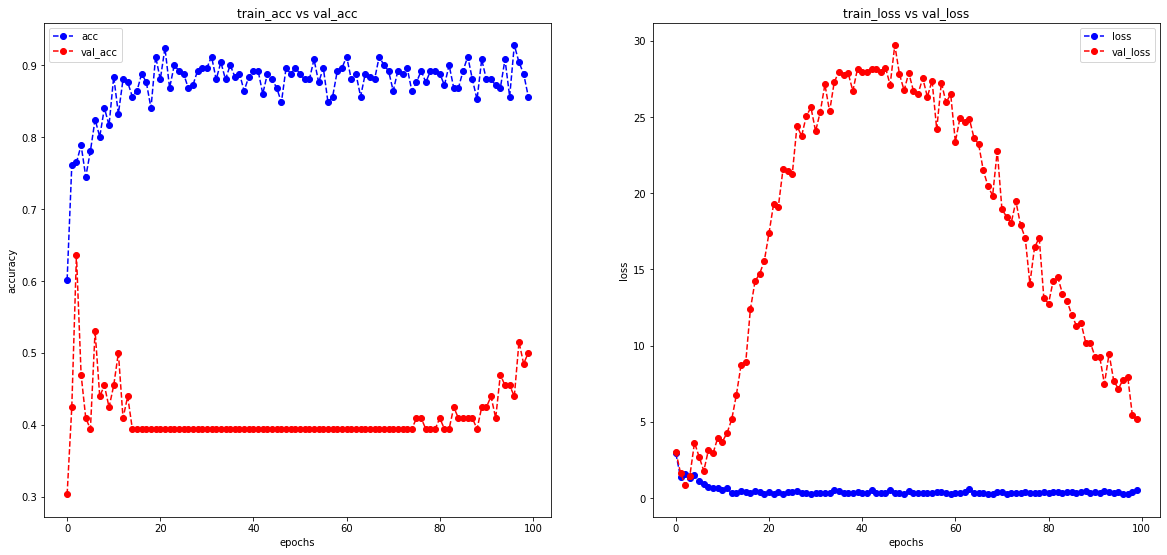

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 120
Epochs: 20
Epoch 1/20
3/3 - 19s - loss: 3.2828 - accuracy: 0.5100 - val_loss: 2.5066 - val_accuracy: 0.3030
Epoch 2/20
3/3 - 14s - loss: 3.0419 - accuracy: 0.7012 - val_loss: 5.4632 - val_accuracy: 0.3030
Epoch 3/20
3/3 - 15s - loss: 2.5701 - accuracy: 0.6972 - val_loss: 8.8345 - val_accuracy: 0.3030
Epoch 4/20
3/3 - 14s - loss: 2.5977 - accuracy: 0.6932 - val_loss: 4.1210 - val_accuracy: 0.3333
Epoch 5/20
3/3 - 15s - loss: 1.3780 - accuracy: 0.7610 - val_loss: 2.6955 - val_accuracy: 0.4242
Epoch 6/20
3/3 - 14s - loss: 1.2157 - accuracy: 0.7928 - val_loss: 5.8023 - val_accuracy: 0.3636
Epoch 7/20
3/3 - 15s - loss: 1.9676 - accuracy: 0.7092 - val_loss: 4.6411 - val_accuracy: 0.3788
Epoch 8/20
3/3 - 14s - loss: 1.3707 - accuracy: 0.7928 - val_loss: 3.2841 - val_accuracy: 0.409

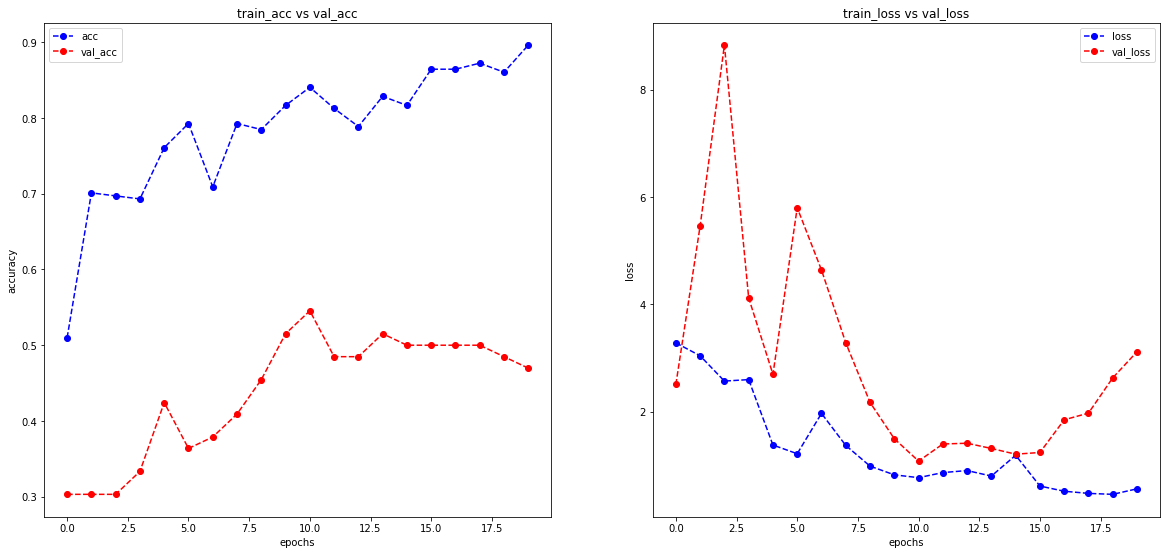

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 120
Epochs: 50
Epoch 1/50
3/3 - 17s - loss: 3.5079 - accuracy: 0.6135 - val_loss: 1.9768 - val_accuracy: 0.3030
Epoch 2/50
3/3 - 14s - loss: 1.6216 - accuracy: 0.7131 - val_loss: 2.9844 - val_accuracy: 0.3030
Epoch 3/50
3/3 - 15s - loss: 1.2684 - accuracy: 0.7689 - val_loss: 3.5022 - val_accuracy: 0.3030
Epoch 4/50
3/3 - 14s - loss: 2.0274 - accuracy: 0.7251 - val_loss: 3.5482 - val_accuracy: 0.2879
Epoch 5/50
3/3 - 15s - loss: 2.1954 - accuracy: 0.7570 - val_loss: 5.6004 - val_accuracy: 0.2424
Epoch 6/50
3/3 - 14s - loss: 1.6272 - accuracy: 0.7809 - val_loss: 7.7503 - val_accuracy: 0.3333
Epoch 7/50
3/3 - 15s - loss: 1.7233 - accuracy: 0.7729 - val_loss: 7.3133 - val_accuracy: 0.3182
Epoch 8/50
3/3 - 14s - loss: 1.2829 - accuracy: 0.8048 - val_loss: 5.8425 - val_accuracy: 0.348

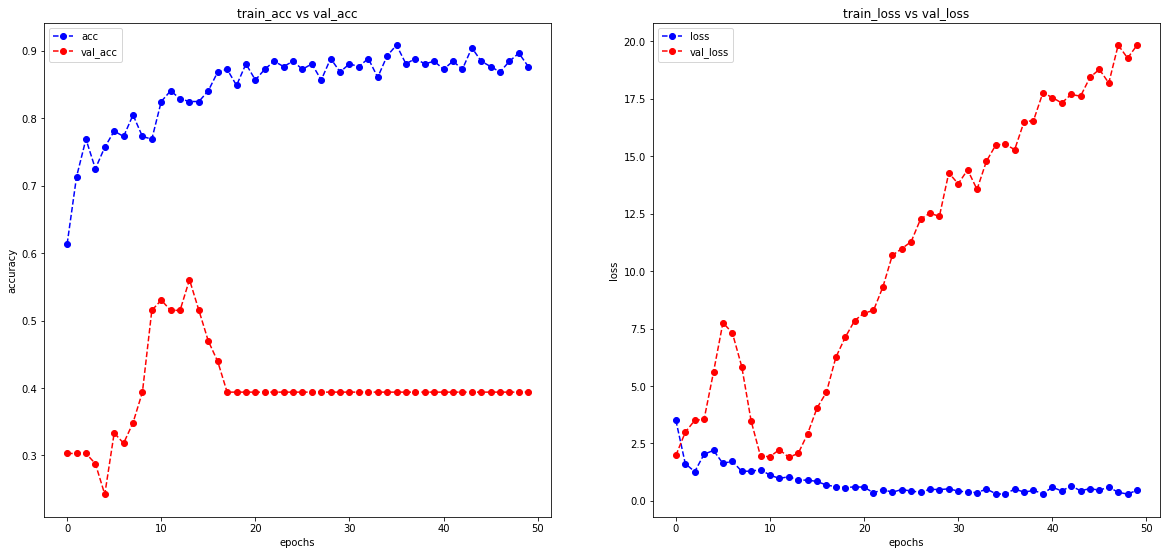

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Label Mappings for classes present in the training and validation datasets

0 : Covid
1 : Normal
2 : Viral Pneumonia
Batch Sizes: 120
Epochs: 100
Epoch 1/100
3/3 - 17s - loss: 4.0310 - accuracy: 0.6056 - val_loss: 2.4222 - val_accuracy: 0.3030
Epoch 2/100
3/3 - 14s - loss: 2.8229 - accuracy: 0.6892 - val_loss: 5.7028 - val_accuracy: 0.3030
Epoch 3/100
3/3 - 15s - loss: 1.6973 - accuracy: 0.7490 - val_loss: 5.4772 - val_accuracy: 0.3030
Epoch 4/100
3/3 - 14s - loss: 1.7301 - accuracy: 0.8048 - val_loss: 4.7418 - val_accuracy: 0.3030
Epoch 5/100
3/3 - 14s - loss: 2.0295 - accuracy: 0.7371 - val_loss: 3.7631 - val_accuracy: 0.3485
Epoch 6/100
3/3 - 14s - loss: 1.3087 - accuracy: 0.7809 - val_loss: 3.2396 - val_accuracy: 0.3485
Epoch 7/100
3/3 - 15s - loss: 0.7314 - accuracy: 0.8645 - val_loss: 1.8638 - val_accuracy: 0.4242
Epoch 8/100
3/3 - 14s - loss: 1.1487 - accuracy: 0.8127 - val_loss: 1.5777 - val_accura

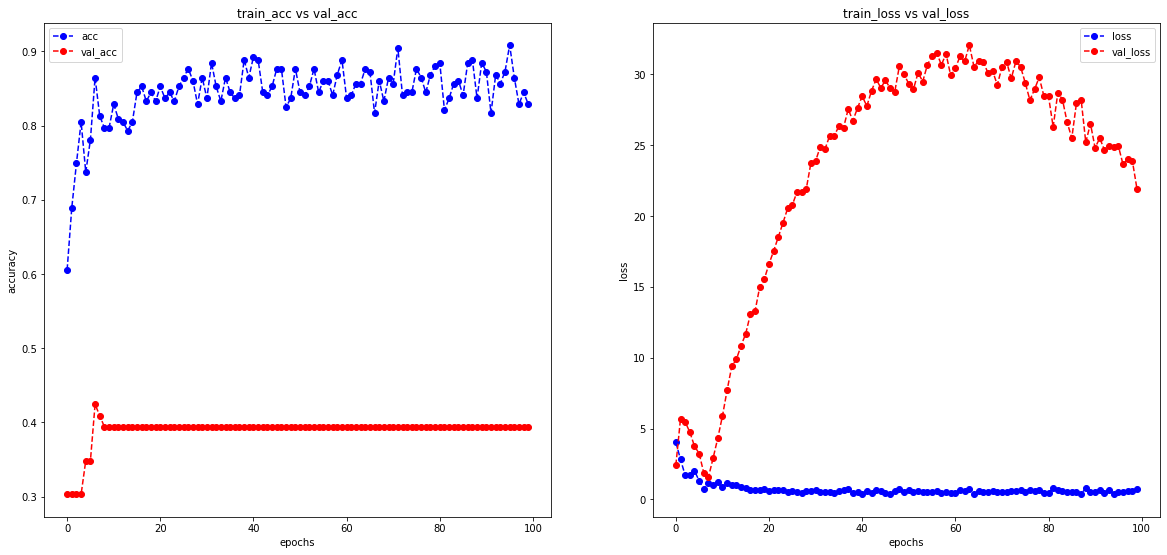

In [99]:
counter=0
for batch in batch_sizes:
    for epoch in epoch_num:
        IMG_WIDTH = 244
        IMG_HEIGHT = 244
        BATCH_SIZE = batch
        train_path="../input/coviddata/train"
        test_path="../input/coviddata/test"
        train_datagen = ImageDataGenerator(rescale=1.0/255,
                                          zoom_range=0.2,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          fill_mode='nearest')
        train_generator = train_datagen.flow_from_directory(train_path,
                                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='categorical',
                                                           shuffle=True)
        validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                                shear_range = 0.3,
                                                horizontal_flip=True,
                                                zoom_range = 0.3)
        validation_generator = validation_datagen.flow_from_directory(test_path,
                                                                     target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                     batch_size=BATCH_SIZE,
                                                                     class_mode='categorical',
                                                                     shuffle=True)
        labels = {value: key for key, value in train_generator.class_indices.items()}

        print("Label Mappings for classes present in the training and validation datasets\n")
        for key, value in labels.items():
            print(f"{key} : {value}")
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
        optimizer = adam_v2.Adam(learning_rate=0.001)
        model=build_model_3()
        if counter==0:
            model.summary()
        
        print("Batch Sizes:",batch)
        print("Epochs:",epoch)
        model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

        history = model.fit(train_generator, epochs=epoch, validation_data=validation_generator,
                               verbose=2,
                               callbacks=[reduce_lr])
        plot_accuracy_loss(history)
        counter+=1

### Resnet

In [52]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 3

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 3

version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [53]:
print(model_type)

ResNet20v1


In [54]:

input_shape = x_train.shape[1:]
print(input_shape)

(244, 244, 3)


In [55]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (251, 244, 244, 3)
251 train samples
66 test samples
y_train shape: (251,)


In [56]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [57]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [58]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [59]:
def resnet_v1(input_shape, depth, num_classes=3):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=3):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [60]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=adam_v2.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'IntelImageClass_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 244, 244, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 244, 244, 16) 64          conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 244, 244, 16) 0           batch_normalization_110[0][0]    
______________________________________________________________________

In [62]:
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).

datagen.fit(x_train)

In [63]:
# Fit the model on the batches generated by datagen.flow().
model.summary()
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 244, 244, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 244, 244, 16) 64          conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 244, 244, 16) 0           batch_normalization_110[0][0]    
____________________________________________________________________________________________

3/3 [==============================] - 0s 34ms/step - loss: 1.0684 - accuracy: 0.8030
Test loss: 1.0683754682540894
Test accuracy: 0.8030303120613098


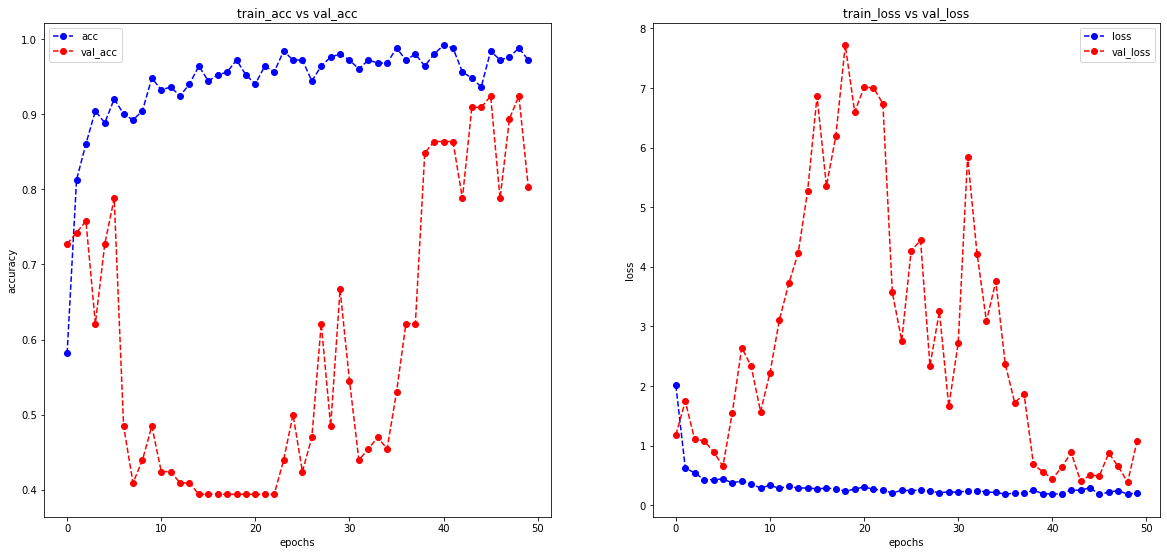

In [64]:
scores = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
plot_accuracy_loss(history)

In [65]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Predicte Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

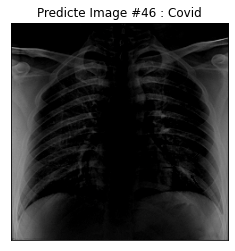

In [66]:
predictions = model.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, x_test, pred_labels)

In [67]:
version=2
data_augmentation=True

In [68]:
# Fit the model on the batches generated by datagen.flow().
model.summary()
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 244, 244, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 244, 244, 16) 64          conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 244, 244, 16) 0           batch_normalization_110[0][0]    
____________________________________________________________________________________________

3/3 [==============================] - 0s 37ms/step - loss: 0.2515 - accuracy: 0.9697
Test loss: 0.2515357732772827
Test accuracy: 0.9696969985961914


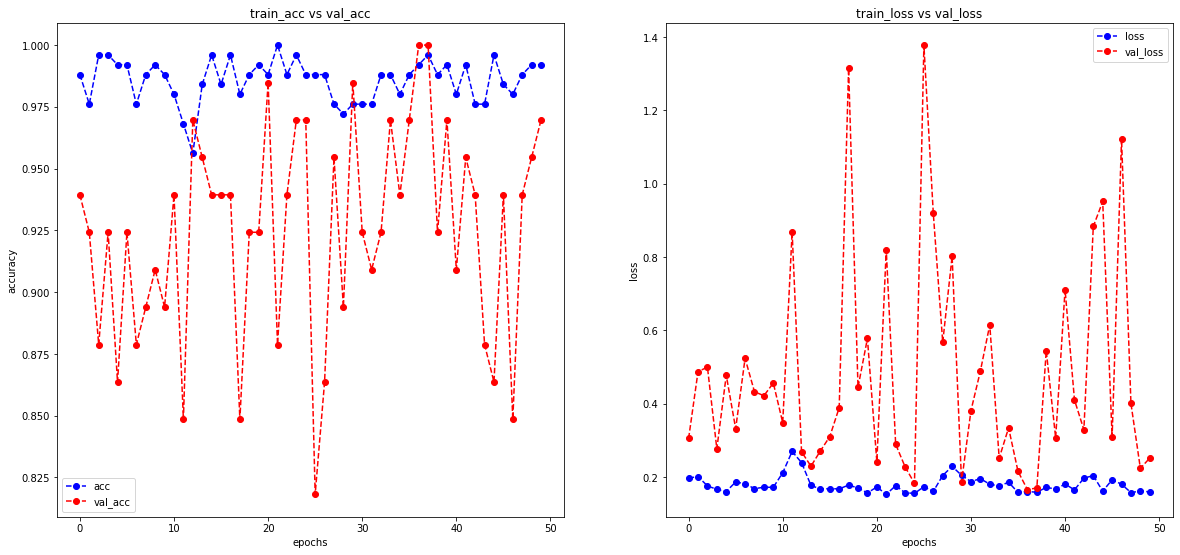

In [69]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
plot_accuracy_loss(history)

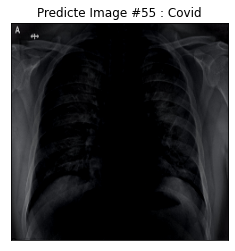

In [70]:
predictions = model.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, x_test, pred_labels)

In [71]:
version=1
data_augmentation=False

In [72]:
# Fit the model on the batches generated by datagen.flow().
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Epoch 1/50
Learning rate:  0.001
8/8 [==============================] - 4s 338ms/step - loss: 0.1489 - accuracy: 0.9960 - val_loss: 0.2304 - val_accuracy: 0.9697
Epoch 2/50
Learning rate:  0.001
8/8 [==============================] - 4s 317ms/step - loss: 0.1633 - accuracy: 0.9880 - val_loss: 0.4516 - val_accuracy: 0.9394
Epoch 3/50
Learning rate:  0.001
8/8 [==============================] - 3s 293ms/step - loss: 0.2062 - accuracy: 0.9801 - val_loss: 0.6116 - val_accuracy: 0.9242
Epoch 4/50
Learning rate:  0.001
8/8 [==============================] - 4s 347ms/step - loss: 0.1878 - accuracy: 0.9801 - val_loss: 0.7900 - val_accuracy: 0.9091
Epoch 5/50
Learning rate:  0.001
8/8 [==============================] - 4s 308ms/step - loss: 0.1470 - accuracy: 0.9960 - val_loss: 0.1959 - val_accuracy: 0.9848
Epoch 6/50
Learning rate:  0.001
8/8 [==============================] - 4s 376ms/step - loss: 0.1633 - accuracy: 0.9920 - val_loss: 0.1766 - val_accuracy: 0.9848
Epoch 7/50
Learning rate:  0

3/3 [==============================] - 0s 41ms/step - loss: 0.4330 - accuracy: 0.9545
Test loss: 0.4330064654350281
Test accuracy: 0.9545454382896423


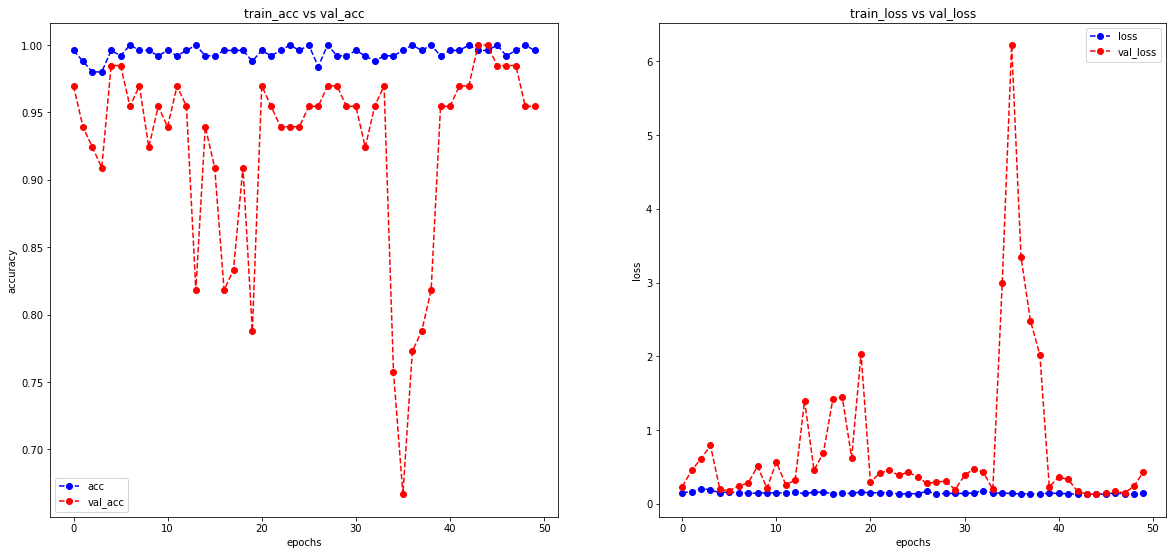

In [73]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
plot_accuracy_loss(history)

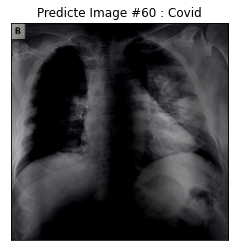

In [74]:
predictions = model.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, x_test, pred_labels)

Epoch 1/50
Learning rate:  0.001
8/8 [==============================] - 4s 377ms/step - loss: 0.1232 - accuracy: 1.0000 - val_loss: 0.7985 - val_accuracy: 0.8636
Epoch 2/50
Learning rate:  0.001
8/8 [==============================] - 3s 306ms/step - loss: 0.1556 - accuracy: 0.9880 - val_loss: 0.6329 - val_accuracy: 0.9394
Epoch 3/50
Learning rate:  0.001
8/8 [==============================] - 4s 353ms/step - loss: 0.1306 - accuracy: 0.9960 - val_loss: 0.4335 - val_accuracy: 0.9242
Epoch 4/50
Learning rate:  0.001
8/8 [==============================] - 3s 298ms/step - loss: 0.1251 - accuracy: 1.0000 - val_loss: 0.5144 - val_accuracy: 0.9091
Epoch 5/50
Learning rate:  0.001
8/8 [==============================] - 3s 303ms/step - loss: 0.1285 - accuracy: 0.9960 - val_loss: 0.3584 - val_accuracy: 0.9394
Epoch 6/50
Learning rate:  0.001
8/8 [==============================] - 3s 282ms/step - loss: 0.1237 - accuracy: 1.0000 - val_loss: 0.2666 - val_accuracy: 0.9394
Epoch 7/50
Learning rate:  0

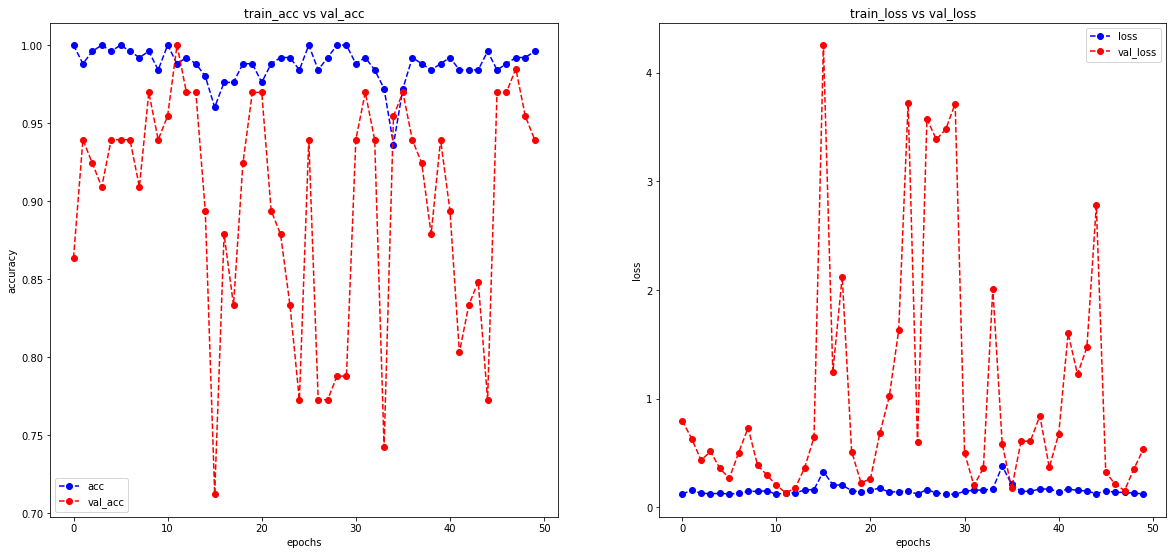

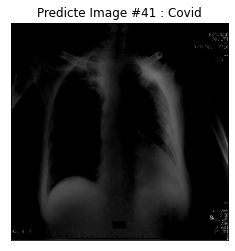

In [75]:
version=2
data_augmentation=False
# Fit the model on the batches generated by datagen.flow().
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
plot_accuracy_loss(history)

predictions = model.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, x_test, pred_labels)